# Neural Network using Pytorch library

In [1]:
import pandas as pd
import torch
from torch import nn
import numpy as np

## Check if hardware accelerators such as GPU or MPS are available, if not CPU

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Read and scale dataset

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('clean.csv')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price']).values, df['price'].values, test_size=0.2, random_state=42)


scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize a scaler for the target variable
y_scaler = MinMaxScaler()

# Reshape y to be a 2D array (required for scalers)
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

## Prepare PyTorch Dataset to convert data from pandas

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch

class FlightDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32, device=device)
        self.y = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)  # Ensure target is 2D for regression

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create PyTorch datasets and data loaders
train_dataset = FlightDataset(X_train_scaled, y_train_scaled)
test_dataset = FlightDataset(X_test_scaled, y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Define PyTorch neural network

In [50]:
DROPOUT_RATE = 0.1

class PricePredictorDropout(nn.Module):
    def __init__(self, input_size):
        super(PricePredictorDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout1 = nn.Dropout(p=DROPOUT_RATE)  # Dropout layer after first layer
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(p=DROPOUT_RATE)  # Dropout layer after second layer
        self.fc3 = nn.Linear(32, 16)
        self.dropout3 = nn.Dropout(p=DROPOUT_RATE)  # Dropout layer after third layer
        self.fc4 = nn.Linear(16, 1)  # Single output for regression

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = self.dropout1(x)
        x = F.tanh(self.fc2(x))
        x = self.dropout2(x)
        x = F.tanh(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x


import torch.nn.functional as F

class PricePredictorL2(nn.Module):
    def __init__(self, input_size):
        super(PricePredictorL2, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)  # Single output for regression

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)
        return x


## Initialize model

In [76]:
input_size = X_train.shape[1]  # Number of features

# Model for Dropout
model_dropout = PricePredictorDropout(input_size).to(device)
print(model_dropout)

criterion = nn.MSELoss()  # Regression loss
optimizer_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)


# Model for L2 regularization
model_l2 = PricePredictorL2(input_size).to(device)
print(model_l2)

optimizer_l2 = torch.optim.AdamW(model_l2.parameters(), lr=0.001, weight_decay=0.1)  # L2 regularization with weight_decay


PricePredictorDropout(
  (fc1): Linear(in_features=27, out_features=64, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (dropout3): Dropout(p=0.1, inplace=False)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)
PricePredictorL2(
  (fc1): Linear(in_features=27, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)


## Train model

In [7]:
def train_model(model, optimizer):
    epochs = 250
    
    for epoch in range(epochs):
        model.train()  # Training model
        total_loss = 0
    
        for inputs, targets in train_loader:
            # Forward pass
            predictions = model(inputs)
            loss = criterion(predictions, targets)
    
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Update weights and biases
            optimizer.step()
    
            total_loss += loss.item()
    
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

In [52]:
train_model(model_dropout, optimizer_dropout)

Epoch [1/250], Loss: 0.0367
Epoch [2/250], Loss: 0.0244
Epoch [3/250], Loss: 0.0210
Epoch [4/250], Loss: 0.0192
Epoch [5/250], Loss: 0.0186
Epoch [6/250], Loss: 0.0178
Epoch [7/250], Loss: 0.0179
Epoch [8/250], Loss: 0.0179
Epoch [9/250], Loss: 0.0176
Epoch [10/250], Loss: 0.0176
Epoch [11/250], Loss: 0.0167
Epoch [12/250], Loss: 0.0167
Epoch [13/250], Loss: 0.0166
Epoch [14/250], Loss: 0.0166
Epoch [15/250], Loss: 0.0170
Epoch [16/250], Loss: 0.0170
Epoch [17/250], Loss: 0.0171
Epoch [18/250], Loss: 0.0165
Epoch [19/250], Loss: 0.0157
Epoch [20/250], Loss: 0.0159
Epoch [21/250], Loss: 0.0161
Epoch [22/250], Loss: 0.0164
Epoch [23/250], Loss: 0.0155
Epoch [24/250], Loss: 0.0156
Epoch [25/250], Loss: 0.0154
Epoch [26/250], Loss: 0.0157
Epoch [27/250], Loss: 0.0157
Epoch [28/250], Loss: 0.0153
Epoch [29/250], Loss: 0.0152
Epoch [30/250], Loss: 0.0149
Epoch [31/250], Loss: 0.0151
Epoch [32/250], Loss: 0.0153
Epoch [33/250], Loss: 0.0152
Epoch [34/250], Loss: 0.0149
Epoch [35/250], Loss: 0

In [77]:
train_model(model_l2, optimizer_l2)

Epoch [1/250], Loss: 0.0518
Epoch [2/250], Loss: 0.0235
Epoch [3/250], Loss: 0.0212
Epoch [4/250], Loss: 0.0199
Epoch [5/250], Loss: 0.0191
Epoch [6/250], Loss: 0.0186
Epoch [7/250], Loss: 0.0177
Epoch [8/250], Loss: 0.0175
Epoch [9/250], Loss: 0.0168
Epoch [10/250], Loss: 0.0165
Epoch [11/250], Loss: 0.0161
Epoch [12/250], Loss: 0.0160
Epoch [13/250], Loss: 0.0159
Epoch [14/250], Loss: 0.0157
Epoch [15/250], Loss: 0.0157
Epoch [16/250], Loss: 0.0155
Epoch [17/250], Loss: 0.0159
Epoch [18/250], Loss: 0.0152
Epoch [19/250], Loss: 0.0153
Epoch [20/250], Loss: 0.0154
Epoch [21/250], Loss: 0.0152
Epoch [22/250], Loss: 0.0151
Epoch [23/250], Loss: 0.0151
Epoch [24/250], Loss: 0.0148
Epoch [25/250], Loss: 0.0147
Epoch [26/250], Loss: 0.0148
Epoch [27/250], Loss: 0.0147
Epoch [28/250], Loss: 0.0145
Epoch [29/250], Loss: 0.0145
Epoch [30/250], Loss: 0.0144
Epoch [31/250], Loss: 0.0145
Epoch [32/250], Loss: 0.0144
Epoch [33/250], Loss: 0.0144
Epoch [34/250], Loss: 0.0145
Epoch [35/250], Loss: 0

## Assess model

In [14]:
def assess_model(model):
    # Ensure model is in evaluation mode
    model.eval()
    
    # Initialize lists to store predictions and real values
    predicted_prices = []
    real_prices = []
    
    # Disable gradient calculation (important for inference mode to save memory and computation)
    with torch.no_grad():
        # Iterate through the DataLoader
        for x, y in test_loader:
            # Forward pass: get predictions
            predicted_price = model(x)  # Make predictions with the model
    
            # Store predictions and real values
            predicted_prices += predicted_price.cpu().numpy().tolist()  # Move to CPU and convert to list
            real_prices += y.cpu().numpy().tolist()  # Move to CPU and convert to list
    
    # Convert lists to numpy arrays for easier handling
    predicted_prices = np.array(predicted_prices)
    real_prices = np.array(real_prices)
    
    # Descale the predicted and real values if necessary
    pred_descaled = y_scaler.inverse_transform(predicted_prices)
    real_descaled = y_scaler.inverse_transform(real_prices)
    
    # Print real vs predicted values
    for real, pred in zip(pred_descaled, real_descaled):
        print(f"Real: {real[0]:.2f} \t Predicted: {pred[0]:.2f}")
    return pred_descaled, real_descaled

## Print error metrics and scatter plot

In [53]:
from utils import print_errors, compute_errors

predicted_prices_descaled, real_prices_descaled = assess_model(model_dropout)
mse, mae, mape = compute_errors(real_prices_descaled, predicted_prices_descaled)
print_errors(mse, mae, mape)

Real: 49277.15 	 Predicted: 45185.00
Real: 69470.39 	 Predicted: 69179.00
Real: 58782.03 	 Predicted: 53937.00
Real: 64800.57 	 Predicted: 55377.00
Real: 39581.81 	 Predicted: 56702.00
Real: 67645.42 	 Predicted: 55502.00
Real: 57688.48 	 Predicted: 55997.00
Real: 50240.31 	 Predicted: 54684.00
Real: 59175.51 	 Predicted: 60978.00
Real: 48896.30 	 Predicted: 53937.00
Real: 51390.36 	 Predicted: 54841.00
Real: 51117.71 	 Predicted: 57017.00
Real: 61671.82 	 Predicted: 60978.00
Real: 51404.56 	 Predicted: 48718.00
Real: 51168.64 	 Predicted: 57017.00
Real: 49226.52 	 Predicted: 49553.00
Real: 26172.10 	 Predicted: 27792.00
Real: 70102.87 	 Predicted: 77329.00
Real: 70116.73 	 Predicted: 62448.00
Real: 54772.06 	 Predicted: 54777.00
Real: 52288.31 	 Predicted: 51707.00
Real: 67000.46 	 Predicted: 73369.00
Real: 41463.17 	 Predicted: 47586.00
Real: 60353.60 	 Predicted: 66077.00
Real: 31547.06 	 Predicted: 34460.00
Real: 69524.81 	 Predicted: 80544.00
Real: 58386.25 	 Predicted: 54608.00
R

In [78]:
from utils import print_errors, compute_errors

predicted_prices_descaled, real_prices_descaled = assess_model(model_l2)
mse, mae, mape = compute_errors(real_prices_descaled, predicted_prices_descaled)
print_errors(mse, mae, mape)

Real: 46216.74 	 Predicted: 45185.00
Real: 60508.50 	 Predicted: 69179.00
Real: 54245.32 	 Predicted: 53937.00
Real: 60928.39 	 Predicted: 55377.00
Real: 44159.03 	 Predicted: 56702.00
Real: 52971.82 	 Predicted: 55502.00
Real: 57307.40 	 Predicted: 55997.00
Real: 54768.10 	 Predicted: 54684.00
Real: 57318.37 	 Predicted: 60978.00
Real: 51576.93 	 Predicted: 53937.00
Real: 52532.78 	 Predicted: 54841.00
Real: 54511.86 	 Predicted: 57017.00
Real: 58942.56 	 Predicted: 60978.00
Real: 49758.29 	 Predicted: 48718.00
Real: 56035.96 	 Predicted: 57017.00
Real: 48573.39 	 Predicted: 49553.00
Real: 27823.96 	 Predicted: 27792.00
Real: 67503.45 	 Predicted: 77329.00
Real: 62362.82 	 Predicted: 62448.00
Real: 50966.37 	 Predicted: 54777.00
Real: 48249.38 	 Predicted: 51707.00
Real: 63727.38 	 Predicted: 73369.00
Real: 38116.51 	 Predicted: 47586.00
Real: 58816.43 	 Predicted: 66077.00
Real: 37852.24 	 Predicted: 34460.00
Real: 59840.29 	 Predicted: 80544.00
Real: 50977.37 	 Predicted: 54608.00
R

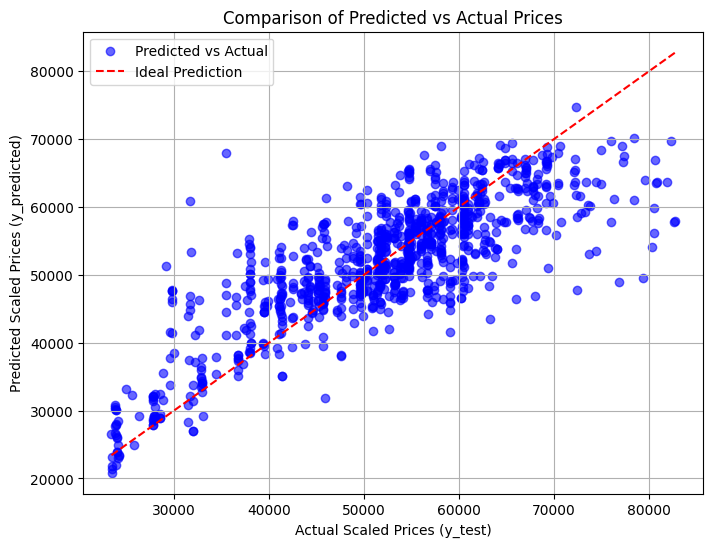

In [79]:
from utils import scatter

scatter(real_prices_descaled, predicted_prices_descaled)